In [1]:
# imports required for the algorithm
import os

import time

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../../data_in/CE_Crateus.csv'
data_output_path = '../../data_out/weather.csv'
data_output_path_npsave = '../../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2015-01-01           0.0        35.0        23.7        5.9              10.2   
2015-01-02           0.0        35.8        23.0       10.6              10.2   
2015-01-03          37.4        31.9        22.3        4.3               6.2   
2015-01-04          12.4        27.3        20.7        1.9               3.5   
2015-01-05          23.0        32.4        20.7        8.3               1.5   
...                  ...         ...         ...        ...               ...   
2018-04-26           0.0        31.0        20.8        8.9               0.5   
2018-04-27           0.0        31.7        22.9       10.5               0.5   
2018-04-28           0.0        31.3        21.5        9.5               0.5   
2018-04-29           3.5        28.9        22.7        2.5               0.5   
2018-04-30           0.4    

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values

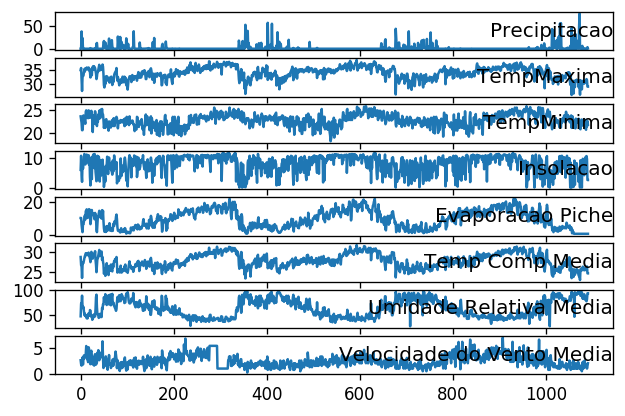

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler * inv_y_hat
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler * inv_y_test
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test, scaler)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
        
    return [y_hats, y_tests]

In [11]:
def metrics(y_hats, y_tests):
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    percentual = 100
    n = len(y_hats)
    j = 1
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    rmse_max = sqrt(mean_squared_error(y_tests_max, y_hats_max))
    variance_max = explained_variance_score(y_tests_max, y_hats_max)
    maxError_max = max_error(y_tests_max, y_hats_max)
    meanAbsolutError_max = mean_absolute_error(y_tests_max, y_hats_max)
    medianAbsoluteError_max = median_absolute_error(y_tests_max, y_hats_max)
    
    rmse_min = sqrt(mean_squared_error(y_tests_min, y_hats_min))
    variance_min = explained_variance_score(y_tests_min, y_hats_min)
    maxError_min = max_error(y_tests_min, y_hats_min)
    meanAbsolutError_min = mean_absolute_error(y_tests_min, y_hats_min)
    medianAbsoluteError_min = median_absolute_error(y_tests_min, y_hats_min)
    
    print('Maximum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_max))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_max))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_max))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_max))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_max))
    
    print('\nErrors')
    for i in range(0,len(y_hats_max)):
        error = abs(y_hats_max[i] - y_tests_max[i])
        print('{}/04/2018 = {}'.format(30-i,error))
    
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_max)):
            error = abs(y_hats_max[i] - y_tests_max[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s) or less'.format(percentual, j))
        j += 1
    
    print('\nMinimum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_min))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_min))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_min))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_min))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_min))
    
    print('\nErrors')
    for i in range(0,len(y_hats_min)):
        error = abs(y_hats_min[i] - y_tests_min[i])
        print('{}/04/2018 = {}'.format(30-i,error))
    
    j = 1
    percentual = 100
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_min)):
            error = abs(y_hats_min[i] - y_tests_min[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s) or less'.format(percentual, j))
        j += 1

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8649 - mean_squared_error: 0.8461 - val_loss: 0.4406 - val_mean_squared_error: 0.2174
Epoch 2/1000
 - 0s - loss: 0.3064 - mean_squared_error: 0.1241 - val_loss: 0.1163 - val_mean_squared_error: 0.0150
Epoch 3/1000
 - 0s - loss: 0.0949 - mean_squared_error: 0.0137 - val_loss: 0.1157 - val_mean_squared_error: 0.0248
Epoch 4/1000
 - 1s - loss: 0.0656 - mean_squared_error: 0.0068 - val_loss: 0.1149 - val_mean_squared_error: 0.0208
Epoch 5/1000
 - 0s - loss: 0.0618 - mean_squared_error: 0.0061 - val_loss: 0.0928 - val_mean_squared_error: 0.0138
Epoch 6/1000
 - 0s - loss: 0.0608 - mean_squared_error: 0.0061 - val_loss: 0.0946 - val_mean_squared_error: 0.0138
Epoch 7/1000
 - 1s - loss: 0.0602 - mean_squared_error: 0.0059 - val_loss: 0.1017 - val_mean_squared_error: 0.0184
Epoch 8/1000
 - 1s - loss: 0.0604 - mean_squared_error: 0.0060 - val_loss: 0.1009 - val_mean_squared_error: 0.0203
Epoch 9/1000
 - 1s - loss: 0.0606 -

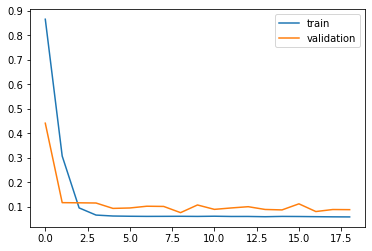


predict: [[31.71948427 22.83601312]]
real:      [[28.9 21.9]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4714 - mean_squared_error: 0.3426 - val_loss: 0.3190 - val_mean_squared_error: 0.1119
Epoch 2/1000
 - 1s - loss: 0.1192 - mean_squared_error: 0.0240 - val_loss: 0.0991 - val_mean_squared_error: 0.0118
Epoch 3/1000
 - 1s - loss: 0.0773 - mean_squared_error: 0.0104 - val_loss: 0.0667 - val_mean_squared_error: 0.0048
Epoch 4/1000
 - 1s - loss: 0.0641 - mean_squared_error: 0.0068 - val_loss: 0.0773 - val_mean_squared_error: 0.0063
Epoch 5/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0060 - val_loss: 0.0650 - val_mean_squared_error: 0.0049
Epoch 6/1000
 - 1s - loss: 0.0591 - mean_squared_error: 0.0058 - val_loss: 0.0773 - val_mean_squared_error: 0.0063
Epoch 7/1000
 - 0s - loss: 0.0595 - mean_squared_error: 0.0059 - val_loss: 0.0750 - val_mean_squared_error: 0.0061
Epoch 8/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0060 - val_loss: 0.0705 - va

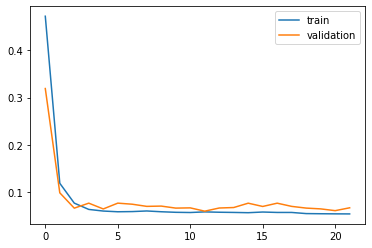


predict: [[32.63261672 22.87115945]]
real:      [[28.9 22.7]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.9764 - mean_squared_error: 1.1639 - val_loss: 0.4184 - val_mean_squared_error: 0.1983
Epoch 2/1000
 - 0s - loss: 0.2084 - mean_squared_error: 0.0832 - val_loss: 0.1535 - val_mean_squared_error: 0.0428
Epoch 3/1000
 - 0s - loss: 0.0844 - mean_squared_error: 0.0122 - val_loss: 0.0392 - val_mean_squared_error: 0.0017
Epoch 4/1000
 - 1s - loss: 0.0674 - mean_squared_error: 0.0078 - val_loss: 0.0509 - val_mean_squared_error: 0.0049
Epoch 5/1000
 - 1s - loss: 0.0622 - mean_squared_error: 0.0064 - val_loss: 0.0510 - val_mean_squared_error: 0.0046
Epoch 6/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0061 - val_loss: 0.0376 - val_mean_squared_error: 0.0025
Epoch 7/1000
 - 1s - loss: 0.0598 - mean_squared_error: 0.0059 - val_loss: 0.0276 - val_mean_squared_error: 0.0014
Epoch 8/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0057 - val_loss: 0.0271 - va

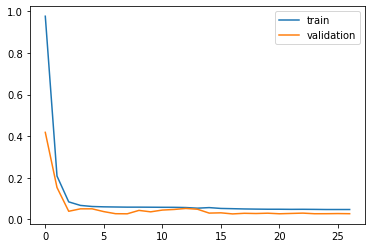


predict: [[32.19239954 22.31605962]]
real:      [[31.3 21.5]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4441 - mean_squared_error: 0.3232 - val_loss: 0.2956 - val_mean_squared_error: 0.0916
Epoch 2/1000
 - 1s - loss: 0.1156 - mean_squared_error: 0.0212 - val_loss: 0.1638 - val_mean_squared_error: 0.0285
Epoch 3/1000
 - 1s - loss: 0.0728 - mean_squared_error: 0.0085 - val_loss: 0.0941 - val_mean_squared_error: 0.0096
Epoch 4/1000
 - 1s - loss: 0.0664 - mean_squared_error: 0.0072 - val_loss: 0.0869 - val_mean_squared_error: 0.0076
Epoch 5/1000
 - 0s - loss: 0.0638 - mean_squared_error: 0.0067 - val_loss: 0.0809 - val_mean_squared_error: 0.0066
Epoch 6/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0059 - val_loss: 0.0658 - val_mean_squared_error: 0.0044
Epoch 7/1000
 - 0s - loss: 0.0594 - mean_squared_error: 0.0059 - val_loss: 0.0745 - val_mean_squared_error: 0.0056
Epoch 8/1000
 - 0s - loss: 0.0588 - mean_squared_error: 0.0057 - val_loss: 0.0711 - va

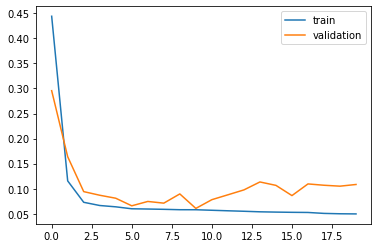


predict: [[31.70231209 22.1506212 ]]
real:      [[31.7 22.9]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6442 - mean_squared_error: 0.6417 - val_loss: 0.3581 - val_mean_squared_error: 0.1636
Epoch 2/1000
 - 1s - loss: 0.2890 - mean_squared_error: 0.1510 - val_loss: 0.0800 - val_mean_squared_error: 0.0086
Epoch 3/1000
 - 0s - loss: 0.0840 - mean_squared_error: 0.0117 - val_loss: 0.1119 - val_mean_squared_error: 0.0189
Epoch 4/1000
 - 1s - loss: 0.0686 - mean_squared_error: 0.0077 - val_loss: 0.1095 - val_mean_squared_error: 0.0123
Epoch 5/1000
 - 0s - loss: 0.0638 - mean_squared_error: 0.0067 - val_loss: 0.1167 - val_mean_squared_error: 0.0152
Epoch 6/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0063 - val_loss: 0.0900 - val_mean_squared_error: 0.0087
Epoch 7/1000
 - 1s - loss: 0.0600 - mean_squared_error: 0.0059 - val_loss: 0.1207 - val_mean_squared_error: 0.0152
Epoch 8/1000
 - 1s - loss: 0.0602 - mean_squared_error: 0.0060 - val_loss: 0.0697 - va

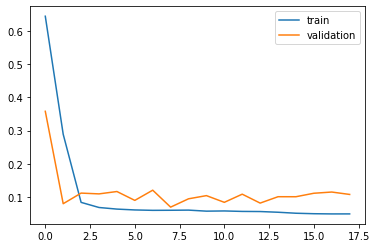


predict: [[32.21728703 21.87907811]]
real:      [[31.  20.8]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5699 - mean_squared_error: 0.5148 - val_loss: 0.1623 - val_mean_squared_error: 0.0271
Epoch 2/1000
 - 0s - loss: 0.1129 - mean_squared_error: 0.0230 - val_loss: 0.0852 - val_mean_squared_error: 0.0074
Epoch 3/1000
 - 0s - loss: 0.0775 - mean_squared_error: 0.0101 - val_loss: 0.1320 - val_mean_squared_error: 0.0218
Epoch 4/1000
 - 1s - loss: 0.0648 - mean_squared_error: 0.0070 - val_loss: 0.0762 - val_mean_squared_error: 0.0067
Epoch 5/1000
 - 0s - loss: 0.0604 - mean_squared_error: 0.0060 - val_loss: 0.0642 - val_mean_squared_error: 0.0043
Epoch 6/1000
 - 0s - loss: 0.0603 - mean_squared_error: 0.0059 - val_loss: 0.0884 - val_mean_squared_error: 0.0080
Epoch 7/1000
 - 1s - loss: 0.0604 - mean_squared_error: 0.0060 - val_loss: 0.0954 - val_mean_squared_error: 0.0093
Epoch 8/1000
 - 1s - loss: 0.0598 - mean_squared_error: 0.0058 - val_loss: 0.0893 - va

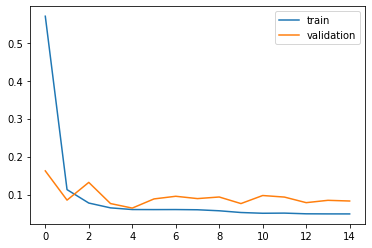


predict: [[31.67312626 22.63005014]]
real:      [[30.7 21. ]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.9292 - mean_squared_error: 1.3561 - val_loss: 0.4778 - val_mean_squared_error: 0.4487
Epoch 2/1000
 - 1s - loss: 0.2995 - mean_squared_error: 0.1985 - val_loss: 0.1893 - val_mean_squared_error: 0.0507
Epoch 3/1000
 - 1s - loss: 0.1015 - mean_squared_error: 0.0173 - val_loss: 0.0322 - val_mean_squared_error: 0.0011
Epoch 4/1000
 - 0s - loss: 0.0698 - mean_squared_error: 0.0078 - val_loss: 0.0853 - val_mean_squared_error: 0.0115
Epoch 5/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0063 - val_loss: 0.0830 - val_mean_squared_error: 0.0096
Epoch 6/1000
 - 1s - loss: 0.0610 - mean_squared_error: 0.0060 - val_loss: 0.0819 - val_mean_squared_error: 0.0091
Epoch 7/1000
 - 1s - loss: 0.0602 - mean_squared_error: 0.0059 - val_loss: 0.0711 - val_mean_squared_error: 0.0065
Epoch 8/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0059 - val_loss: 0.0758 - va

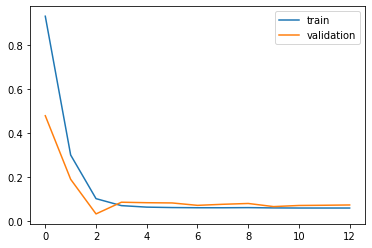


predict: [[30.94999154 22.07367854]]
real:      [[30.6 21.7]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.0774 - mean_squared_error: 1.3849 - val_loss: 0.6241 - val_mean_squared_error: 0.6689
Epoch 2/1000
 - 1s - loss: 0.6452 - mean_squared_error: 0.7259 - val_loss: 0.3846 - val_mean_squared_error: 0.2928
Epoch 3/1000
 - 1s - loss: 0.3875 - mean_squared_error: 0.2737 - val_loss: 0.0952 - val_mean_squared_error: 0.0121
Epoch 4/1000
 - 1s - loss: 0.1067 - mean_squared_error: 0.0216 - val_loss: 0.1455 - val_mean_squared_error: 0.0396
Epoch 5/1000
 - 1s - loss: 0.0716 - mean_squared_error: 0.0086 - val_loss: 0.0770 - val_mean_squared_error: 0.0115
Epoch 6/1000
 - 1s - loss: 0.0660 - mean_squared_error: 0.0074 - val_loss: 0.1079 - val_mean_squared_error: 0.0211
Epoch 7/1000
 - 1s - loss: 0.0642 - mean_squared_error: 0.0067 - val_loss: 0.0957 - val_mean_squared_error: 0.0162
Epoch 8/1000
 - 1s - loss: 0.0625 - mean_squared_error: 0.0065 - val_loss: 0.0962 - va

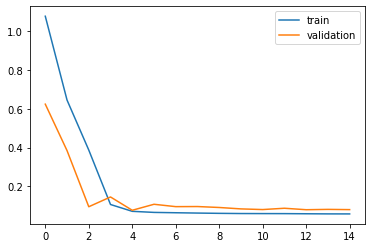


predict: [[33.31271776 23.11108831]]
real:      [[30.3 22.3]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8461 - mean_squared_error: 0.8345 - val_loss: 0.4917 - val_mean_squared_error: 0.3180
Epoch 2/1000
 - 1s - loss: 0.1980 - mean_squared_error: 0.0741 - val_loss: 0.1085 - val_mean_squared_error: 0.0136
Epoch 3/1000
 - 1s - loss: 0.0773 - mean_squared_error: 0.0092 - val_loss: 0.0717 - val_mean_squared_error: 0.0056
Epoch 4/1000
 - 0s - loss: 0.0671 - mean_squared_error: 0.0073 - val_loss: 0.0540 - val_mean_squared_error: 0.0038
Epoch 5/1000
 - 0s - loss: 0.0621 - mean_squared_error: 0.0063 - val_loss: 0.0412 - val_mean_squared_error: 0.0028
Epoch 6/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0061 - val_loss: 0.0484 - val_mean_squared_error: 0.0030
Epoch 7/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0060 - val_loss: 0.0241 - val_mean_squared_error: 0.0011
Epoch 8/1000
 - 1s - loss: 0.0622 - mean_squared_error: 0.0063 - val_loss: 0.0342 - va

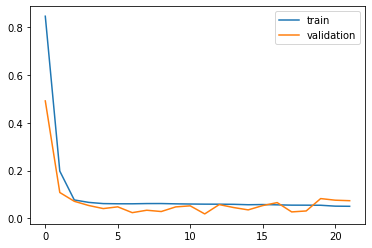


predict: [[31.67967699 22.62111997]]
real:      [[30.  23.1]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7424 - mean_squared_error: 0.6990 - val_loss: 0.0564 - val_mean_squared_error: 0.0046
Epoch 2/1000
 - 0s - loss: 0.1258 - mean_squared_error: 0.0232 - val_loss: 0.0532 - val_mean_squared_error: 0.0035
Epoch 3/1000
 - 1s - loss: 0.0703 - mean_squared_error: 0.0080 - val_loss: 0.0195 - val_mean_squared_error: 4.0347e-04
Epoch 4/1000
 - 1s - loss: 0.0663 - mean_squared_error: 0.0070 - val_loss: 0.0405 - val_mean_squared_error: 0.0020
Epoch 5/1000
 - 1s - loss: 0.0625 - mean_squared_error: 0.0063 - val_loss: 0.0579 - val_mean_squared_error: 0.0036
Epoch 6/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0060 - val_loss: 0.0517 - val_mean_squared_error: 0.0037
Epoch 7/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0059 - val_loss: 0.0554 - val_mean_squared_error: 0.0048
Epoch 8/1000
 - 0s - loss: 0.0603 - mean_squared_error: 0.0060 - val_loss: 0.0489 

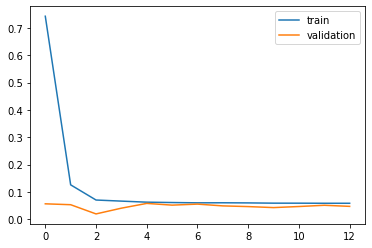


predict: [[30.83349436 21.83307741]]
real:      [[31.1 22.8]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5580 - mean_squared_error: 0.4687 - val_loss: 0.2827 - val_mean_squared_error: 0.1209
Epoch 2/1000
 - 1s - loss: 0.1230 - mean_squared_error: 0.0268 - val_loss: 0.0287 - val_mean_squared_error: 0.0010
Epoch 3/1000
 - 1s - loss: 0.0751 - mean_squared_error: 0.0096 - val_loss: 0.0924 - val_mean_squared_error: 0.0152
Epoch 4/1000
 - 1s - loss: 0.0666 - mean_squared_error: 0.0072 - val_loss: 0.0781 - val_mean_squared_error: 0.0109
Epoch 5/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0066 - val_loss: 0.0630 - val_mean_squared_error: 0.0071
Epoch 6/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0061 - val_loss: 0.0671 - val_mean_squared_error: 0.0068
Epoch 7/1000
 - 1s - loss: 0.0602 - mean_squared_error: 0.0059 - val_loss: 0.0604 - val_mean_squared_error: 0.0052
Epoch 8/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0058 - val_loss: 0.0620 - va

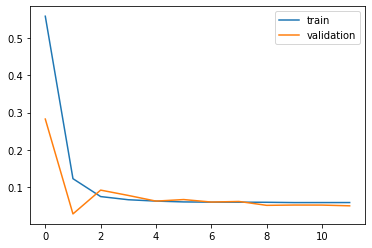


predict: [[31.69599163 23.33725666]]
real:      [[31.1 22.3]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.1590 - mean_squared_error: 1.3998 - val_loss: 0.7344 - val_mean_squared_error: 0.5539
Epoch 2/1000
 - 1s - loss: 0.5954 - mean_squared_error: 0.4423 - val_loss: 0.2618 - val_mean_squared_error: 0.0837
Epoch 3/1000
 - 1s - loss: 0.1367 - mean_squared_error: 0.0319 - val_loss: 0.1912 - val_mean_squared_error: 0.0459
Epoch 4/1000
 - 1s - loss: 0.0777 - mean_squared_error: 0.0097 - val_loss: 0.0833 - val_mean_squared_error: 0.0073
Epoch 5/1000
 - 1s - loss: 0.0696 - mean_squared_error: 0.0077 - val_loss: 0.0936 - val_mean_squared_error: 0.0093
Epoch 6/1000
 - 1s - loss: 0.0659 - mean_squared_error: 0.0068 - val_loss: 0.1131 - val_mean_squared_error: 0.0144
Epoch 7/1000
 - 1s - loss: 0.0641 - mean_squared_error: 0.0065 - val_loss: 0.0767 - val_mean_squared_error: 0.0062
Epoch 8/1000
 - 1s - loss: 0.0629 - mean_squared_error: 0.0063 - val_loss: 0.0892 - va

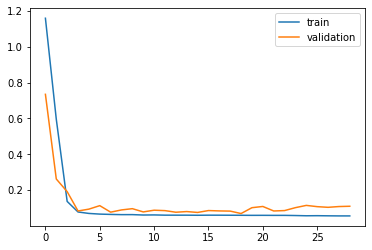


predict: [[31.0819749  22.48333225]]
real:      [[31.  22.8]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6181 - mean_squared_error: 0.6338 - val_loss: 0.2927 - val_mean_squared_error: 0.1032
Epoch 2/1000
 - 1s - loss: 0.1240 - mean_squared_error: 0.0229 - val_loss: 0.1597 - val_mean_squared_error: 0.0297
Epoch 3/1000
 - 1s - loss: 0.0748 - mean_squared_error: 0.0085 - val_loss: 0.1201 - val_mean_squared_error: 0.0283
Epoch 4/1000
 - 1s - loss: 0.0640 - mean_squared_error: 0.0064 - val_loss: 0.1294 - val_mean_squared_error: 0.0293
Epoch 5/1000
 - 1s - loss: 0.0618 - mean_squared_error: 0.0061 - val_loss: 0.1108 - val_mean_squared_error: 0.0220
Epoch 6/1000
 - 1s - loss: 0.0600 - mean_squared_error: 0.0058 - val_loss: 0.1203 - val_mean_squared_error: 0.0283
Epoch 7/1000
 - 1s - loss: 0.0624 - mean_squared_error: 0.0064 - val_loss: 0.1360 - val_mean_squared_error: 0.0334
Epoch 8/1000
 - 1s - loss: 0.0610 - mean_squared_error: 0.0061 - val_loss: 0.1004 - va

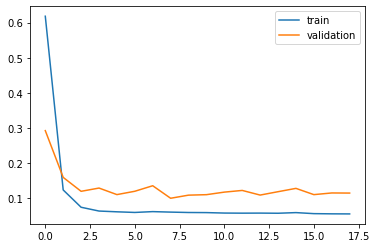


predict: [[30.91108945 22.68302505]]
real:      [[30.7 21.7]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.0807 - mean_squared_error: 1.2793 - val_loss: 0.5859 - val_mean_squared_error: 0.3433
Epoch 2/1000
 - 1s - loss: 0.3400 - mean_squared_error: 0.1734 - val_loss: 0.2199 - val_mean_squared_error: 0.0636
Epoch 3/1000
 - 1s - loss: 0.1012 - mean_squared_error: 0.0158 - val_loss: 0.1146 - val_mean_squared_error: 0.0148
Epoch 4/1000
 - 1s - loss: 0.0735 - mean_squared_error: 0.0084 - val_loss: 0.1315 - val_mean_squared_error: 0.0309
Epoch 5/1000
 - 1s - loss: 0.0649 - mean_squared_error: 0.0067 - val_loss: 0.0947 - val_mean_squared_error: 0.0163
Epoch 6/1000
 - 1s - loss: 0.0627 - mean_squared_error: 0.0062 - val_loss: 0.0935 - val_mean_squared_error: 0.0167
Epoch 7/1000
 - 1s - loss: 0.0616 - mean_squared_error: 0.0060 - val_loss: 0.0869 - val_mean_squared_error: 0.0148
Epoch 8/1000
 - 1s - loss: 0.0614 - mean_squared_error: 0.0061 - val_loss: 0.0736 - va

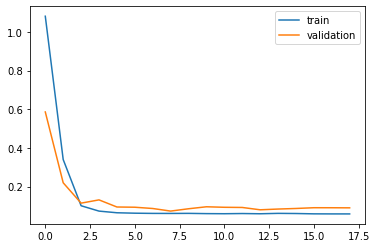


predict: [[32.20013602 23.10317979]]
real:      [[27.9 23. ]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4101 - mean_squared_error: 0.2590 - val_loss: 0.1616 - val_mean_squared_error: 0.0268
Epoch 2/1000
 - 1s - loss: 0.1134 - mean_squared_error: 0.0208 - val_loss: 0.0991 - val_mean_squared_error: 0.0164
Epoch 3/1000
 - 1s - loss: 0.0777 - mean_squared_error: 0.0095 - val_loss: 0.0945 - val_mean_squared_error: 0.0128
Epoch 4/1000
 - 1s - loss: 0.0666 - mean_squared_error: 0.0072 - val_loss: 0.0937 - val_mean_squared_error: 0.0096
Epoch 5/1000
 - 1s - loss: 0.0633 - mean_squared_error: 0.0066 - val_loss: 0.0881 - val_mean_squared_error: 0.0088
Epoch 6/1000
 - 1s - loss: 0.0614 - mean_squared_error: 0.0061 - val_loss: 0.0911 - val_mean_squared_error: 0.0090
Epoch 7/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0059 - val_loss: 0.0770 - val_mean_squared_error: 0.0064
Epoch 8/1000
 - 1s - loss: 0.0576 - mean_squared_error: 0.0056 - val_loss: 0.0933 - va

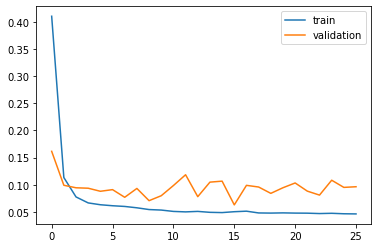


predict: [[31.2512776  22.11142003]]
real:      [[29.5 23. ]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.8161 - mean_squared_error: 0.9010 - val_loss: 0.3396 - val_mean_squared_error: 0.1703
Epoch 2/1000
 - 1s - loss: 0.1870 - mean_squared_error: 0.0729 - val_loss: 0.2444 - val_mean_squared_error: 0.0684
Epoch 3/1000
 - 1s - loss: 0.0883 - mean_squared_error: 0.0134 - val_loss: 0.0722 - val_mean_squared_error: 0.0052
Epoch 4/1000
 - 1s - loss: 0.0709 - mean_squared_error: 0.0084 - val_loss: 0.1200 - val_mean_squared_error: 0.0153
Epoch 5/1000
 - 1s - loss: 0.0638 - mean_squared_error: 0.0065 - val_loss: 0.1111 - val_mean_squared_error: 0.0125
Epoch 6/1000
 - 1s - loss: 0.0620 - mean_squared_error: 0.0063 - val_loss: 0.0884 - val_mean_squared_error: 0.0078
Epoch 7/1000
 - 1s - loss: 0.0605 - mean_squared_error: 0.0060 - val_loss: 0.0697 - val_mean_squared_error: 0.0049
Epoch 8/1000
 - 1s - loss: 0.0614 - mean_squared_error: 0.0062 - val_loss: 0.0953 - va

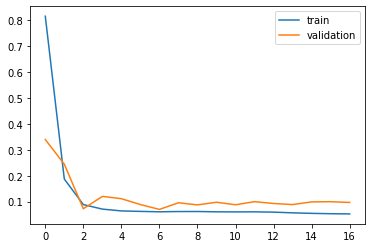


predict: [[30.96182256 22.31590876]]
real:      [[30.7 21.8]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7432 - mean_squared_error: 0.8268 - val_loss: 0.1014 - val_mean_squared_error: 0.0105
Epoch 2/1000
 - 1s - loss: 0.1272 - mean_squared_error: 0.0277 - val_loss: 0.2075 - val_mean_squared_error: 0.0821
Epoch 3/1000
 - 1s - loss: 0.0800 - mean_squared_error: 0.0099 - val_loss: 0.2033 - val_mean_squared_error: 0.0589
Epoch 4/1000
 - 1s - loss: 0.0679 - mean_squared_error: 0.0074 - val_loss: 0.2460 - val_mean_squared_error: 0.0795
Epoch 5/1000
 - 1s - loss: 0.0648 - mean_squared_error: 0.0069 - val_loss: 0.1938 - val_mean_squared_error: 0.0568
Epoch 6/1000
 - 1s - loss: 0.0621 - mean_squared_error: 0.0063 - val_loss: 0.2424 - val_mean_squared_error: 0.0763
Epoch 7/1000
 - 1s - loss: 0.0627 - mean_squared_error: 0.0065 - val_loss: 0.2043 - val_mean_squared_error: 0.0577
Epoch 8/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0059 - val_loss: 0.2221 - va

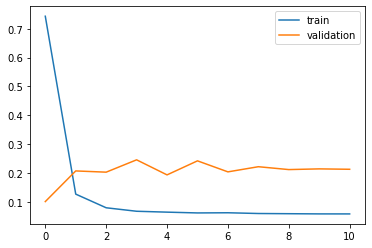


predict: [[29.72765922 26.38061327]]
real:      [[31.3 20.9]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.9044 - mean_squared_error: 0.9565 - val_loss: 0.2096 - val_mean_squared_error: 0.0665
Epoch 2/1000
 - 1s - loss: 0.1840 - mean_squared_error: 0.0671 - val_loss: 0.2127 - val_mean_squared_error: 0.0546
Epoch 3/1000
 - 1s - loss: 0.0828 - mean_squared_error: 0.0108 - val_loss: 0.1656 - val_mean_squared_error: 0.0354
Epoch 4/1000
 - 1s - loss: 0.0695 - mean_squared_error: 0.0078 - val_loss: 0.1373 - val_mean_squared_error: 0.0195
Epoch 5/1000
 - 1s - loss: 0.0639 - mean_squared_error: 0.0065 - val_loss: 0.1360 - val_mean_squared_error: 0.0198
Epoch 6/1000
 - 1s - loss: 0.0607 - mean_squared_error: 0.0060 - val_loss: 0.1322 - val_mean_squared_error: 0.0194
Epoch 7/1000
 - 1s - loss: 0.0605 - mean_squared_error: 0.0060 - val_loss: 0.1245 - val_mean_squared_error: 0.0188
Epoch 8/1000
 - 1s - loss: 0.0595 - mean_squared_error: 0.0058 - val_loss: 0.1260 - va

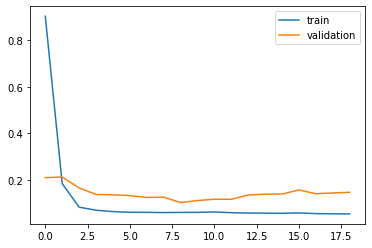


predict: [[31.39840044 20.63160553]]
real:      [[25.9 21.2]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.0222 - mean_squared_error: 1.5358 - val_loss: 0.5567 - val_mean_squared_error: 0.5510
Epoch 2/1000
 - 1s - loss: 0.5441 - mean_squared_error: 0.5434 - val_loss: 0.3586 - val_mean_squared_error: 0.2066
Epoch 3/1000
 - 1s - loss: 0.2885 - mean_squared_error: 0.1602 - val_loss: 0.0571 - val_mean_squared_error: 0.0036
Epoch 4/1000
 - 1s - loss: 0.0830 - mean_squared_error: 0.0123 - val_loss: 0.1242 - val_mean_squared_error: 0.0161
Epoch 5/1000
 - 1s - loss: 0.0724 - mean_squared_error: 0.0085 - val_loss: 0.1149 - val_mean_squared_error: 0.0143
Epoch 6/1000
 - 1s - loss: 0.0677 - mean_squared_error: 0.0077 - val_loss: 0.1048 - val_mean_squared_error: 0.0113
Epoch 7/1000
 - 1s - loss: 0.0659 - mean_squared_error: 0.0070 - val_loss: 0.1129 - val_mean_squared_error: 0.0149
Epoch 8/1000
 - 1s - loss: 0.0648 - mean_squared_error: 0.0071 - val_loss: 0.0898 - va

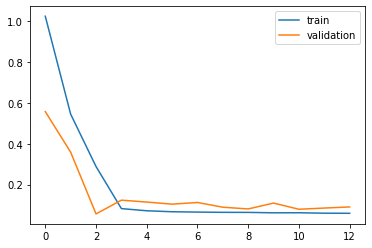


predict: [[31.33413974 22.02918649]]
real:      [[29.2 21.1]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.8071 - mean_squared_error: 0.8100 - val_loss: 0.0572 - val_mean_squared_error: 0.0040
Epoch 2/1000
 - 1s - loss: 0.1407 - mean_squared_error: 0.0372 - val_loss: 0.1385 - val_mean_squared_error: 0.0335
Epoch 3/1000
 - 1s - loss: 0.0811 - mean_squared_error: 0.0101 - val_loss: 0.1537 - val_mean_squared_error: 0.0455
Epoch 4/1000
 - 1s - loss: 0.0685 - mean_squared_error: 0.0077 - val_loss: 0.1177 - val_mean_squared_error: 0.0273
Epoch 5/1000
 - 1s - loss: 0.0647 - mean_squared_error: 0.0069 - val_loss: 0.1184 - val_mean_squared_error: 0.0225
Epoch 6/1000
 - 1s - loss: 0.0634 - mean_squared_error: 0.0064 - val_loss: 0.1051 - val_mean_squared_error: 0.0187
Epoch 7/1000
 - 1s - loss: 0.0620 - mean_squared_error: 0.0063 - val_loss: 0.1086 - val_mean_squared_error: 0.0195
Epoch 8/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0062 - val_loss: 0.1000 - va

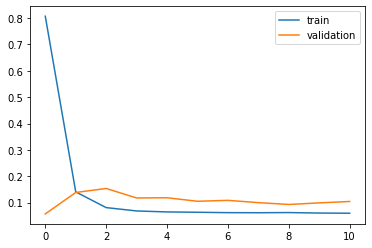


predict: [[27.7521382  23.90148781]]
real:      [[31.1 21.7]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.2251 - mean_squared_error: 1.9809 - val_loss: 0.8930 - val_mean_squared_error: 1.4498
Epoch 2/1000
 - 1s - loss: 0.8450 - mean_squared_error: 1.3143 - val_loss: 0.6699 - val_mean_squared_error: 0.8281
Epoch 3/1000
 - 1s - loss: 0.6476 - mean_squared_error: 0.7645 - val_loss: 0.5078 - val_mean_squared_error: 0.4513
Epoch 4/1000
 - 1s - loss: 0.4994 - mean_squared_error: 0.4563 - val_loss: 0.3562 - val_mean_squared_error: 0.1979
Epoch 5/1000
 - 1s - loss: 0.2953 - mean_squared_error: 0.1586 - val_loss: 0.0548 - val_mean_squared_error: 0.0031
Epoch 6/1000
 - 1s - loss: 0.0870 - mean_squared_error: 0.0125 - val_loss: 0.0865 - val_mean_squared_error: 0.0140
Epoch 7/1000
 - 1s - loss: 0.0669 - mean_squared_error: 0.0073 - val_loss: 0.0405 - val_mean_squared_error: 0.0030
Epoch 8/1000
 - 1s - loss: 0.0652 - mean_squared_error: 0.0069 - val_loss: 0.0821 - va

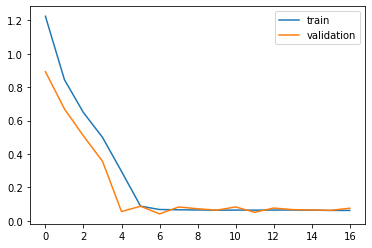


predict: [[32.85935147 22.46223757]]
real:      [[28.7 23.2]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5919 - mean_squared_error: 0.5751 - val_loss: 0.2624 - val_mean_squared_error: 0.0828
Epoch 2/1000
 - 1s - loss: 0.1997 - mean_squared_error: 0.0624 - val_loss: 0.1150 - val_mean_squared_error: 0.0158
Epoch 3/1000
 - 1s - loss: 0.0855 - mean_squared_error: 0.0117 - val_loss: 0.0795 - val_mean_squared_error: 0.0109
Epoch 4/1000
 - 1s - loss: 0.0666 - mean_squared_error: 0.0072 - val_loss: 0.0716 - val_mean_squared_error: 0.0101
Epoch 5/1000
 - 1s - loss: 0.0623 - mean_squared_error: 0.0065 - val_loss: 0.0420 - val_mean_squared_error: 0.0034
Epoch 6/1000
 - 1s - loss: 0.0605 - mean_squared_error: 0.0061 - val_loss: 0.0482 - val_mean_squared_error: 0.0042
Epoch 7/1000
 - 1s - loss: 0.0598 - mean_squared_error: 0.0061 - val_loss: 0.0684 - val_mean_squared_error: 0.0072
Epoch 8/1000
 - 1s - loss: 0.0564 - mean_squared_error: 0.0055 - val_loss: 0.0601 - va

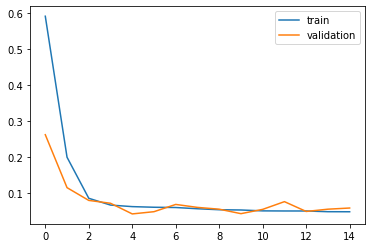


predict: [[32.32231049 21.72826304]]
real:      [[31.2 22.3]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6765 - mean_squared_error: 0.6330 - val_loss: 0.1883 - val_mean_squared_error: 0.0357
Epoch 2/1000
 - 1s - loss: 0.1291 - mean_squared_error: 0.0247 - val_loss: 0.0699 - val_mean_squared_error: 0.0068
Epoch 3/1000
 - 1s - loss: 0.0762 - mean_squared_error: 0.0088 - val_loss: 0.0966 - val_mean_squared_error: 0.0096
Epoch 4/1000
 - 1s - loss: 0.0657 - mean_squared_error: 0.0067 - val_loss: 0.0490 - val_mean_squared_error: 0.0045
Epoch 5/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0059 - val_loss: 0.0509 - val_mean_squared_error: 0.0044
Epoch 6/1000
 - 1s - loss: 0.0589 - mean_squared_error: 0.0057 - val_loss: 0.0548 - val_mean_squared_error: 0.0053
Epoch 7/1000
 - 1s - loss: 0.0576 - mean_squared_error: 0.0055 - val_loss: 0.0484 - val_mean_squared_error: 0.0045
Epoch 8/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0054 - val_loss: 0.0519 - va

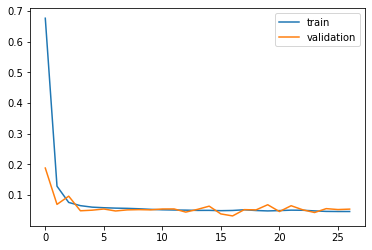


predict: [[30.50688145 22.41675828]]
real:      [[31.1 22.3]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5852 - mean_squared_error: 0.5090 - val_loss: 0.2722 - val_mean_squared_error: 0.1017
Epoch 2/1000
 - 1s - loss: 0.1881 - mean_squared_error: 0.0561 - val_loss: 0.0378 - val_mean_squared_error: 0.0024
Epoch 3/1000
 - 1s - loss: 0.0796 - mean_squared_error: 0.0108 - val_loss: 0.0801 - val_mean_squared_error: 0.0067
Epoch 4/1000
 - 1s - loss: 0.0678 - mean_squared_error: 0.0075 - val_loss: 0.0280 - val_mean_squared_error: 0.0012
Epoch 5/1000
 - 1s - loss: 0.0637 - mean_squared_error: 0.0065 - val_loss: 0.0388 - val_mean_squared_error: 0.0020
Epoch 6/1000
 - 1s - loss: 0.0621 - mean_squared_error: 0.0063 - val_loss: 0.0356 - val_mean_squared_error: 0.0015
Epoch 7/1000
 - 1s - loss: 0.0605 - mean_squared_error: 0.0059 - val_loss: 0.0443 - val_mean_squared_error: 0.0035
Epoch 8/1000
 - 1s - loss: 0.0593 - mean_squared_error: 0.0058 - val_loss: 0.0400 - va

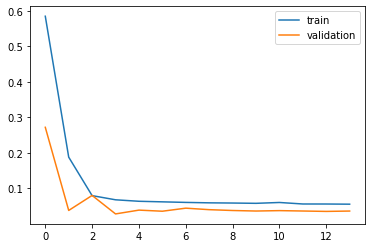


predict: [[31.77100082 22.36889691]]
real:      [[31.  22.8]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.1124 - mean_squared_error: 1.2947 - val_loss: 0.6783 - val_mean_squared_error: 0.4911
Epoch 2/1000
 - 1s - loss: 0.5128 - mean_squared_error: 0.3447 - val_loss: 0.4408 - val_mean_squared_error: 0.2139
Epoch 3/1000
 - 1s - loss: 0.2045 - mean_squared_error: 0.0667 - val_loss: 0.1195 - val_mean_squared_error: 0.0181
Epoch 4/1000
 - 1s - loss: 0.0882 - mean_squared_error: 0.0119 - val_loss: 0.0593 - val_mean_squared_error: 0.0062
Epoch 5/1000
 - 1s - loss: 0.0687 - mean_squared_error: 0.0073 - val_loss: 0.0773 - val_mean_squared_error: 0.0076
Epoch 6/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0063 - val_loss: 0.0555 - val_mean_squared_error: 0.0049
Epoch 7/1000
 - 1s - loss: 0.0622 - mean_squared_error: 0.0061 - val_loss: 0.0676 - val_mean_squared_error: 0.0066
Epoch 8/1000
 - 1s - loss: 0.0610 - mean_squared_error: 0.0059 - val_loss: 0.0592 - va

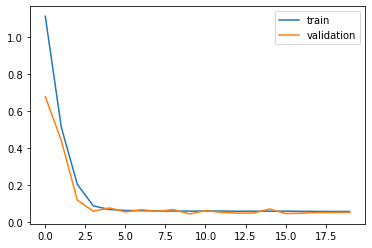


predict: [[32.04381039 22.85341821]]
real:      [[31.5 23. ]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.1293 - mean_squared_error: 1.3767 - val_loss: 0.5562 - val_mean_squared_error: 0.3171
Epoch 2/1000
 - 1s - loss: 0.2738 - mean_squared_error: 0.1206 - val_loss: 0.2345 - val_mean_squared_error: 0.0599
Epoch 3/1000
 - 1s - loss: 0.0970 - mean_squared_error: 0.0152 - val_loss: 0.0163 - val_mean_squared_error: 2.9477e-04
Epoch 4/1000
 - 1s - loss: 0.0698 - mean_squared_error: 0.0079 - val_loss: 0.0866 - val_mean_squared_error: 0.0111
Epoch 5/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0063 - val_loss: 0.0461 - val_mean_squared_error: 0.0041
Epoch 6/1000
 - 1s - loss: 0.0604 - mean_squared_error: 0.0059 - val_loss: 0.0442 - val_mean_squared_error: 0.0032
Epoch 7/1000
 - 1s - loss: 0.0592 - mean_squared_error: 0.0057 - val_loss: 0.0440 - val_mean_squared_error: 0.0036
Epoch 8/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0054 - val_loss: 0.0588 

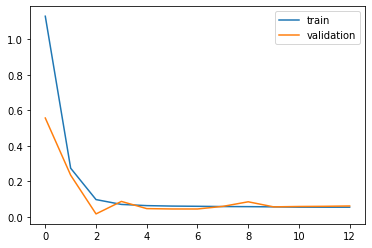


predict: [[31.41001178 23.40081597]]
real:      [[30.9 22.9]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.9735 - mean_squared_error: 1.2792 - val_loss: 0.6133 - val_mean_squared_error: 0.5412
Epoch 2/1000
 - 1s - loss: 0.4705 - mean_squared_error: 0.3862 - val_loss: 0.3576 - val_mean_squared_error: 0.1534
Epoch 3/1000
 - 1s - loss: 0.2894 - mean_squared_error: 0.1472 - val_loss: 0.0713 - val_mean_squared_error: 0.0061
Epoch 4/1000
 - 1s - loss: 0.0925 - mean_squared_error: 0.0151 - val_loss: 0.0991 - val_mean_squared_error: 0.0110
Epoch 5/1000
 - 1s - loss: 0.0722 - mean_squared_error: 0.0086 - val_loss: 0.1110 - val_mean_squared_error: 0.0142
Epoch 6/1000
 - 1s - loss: 0.0652 - mean_squared_error: 0.0073 - val_loss: 0.0790 - val_mean_squared_error: 0.0063
Epoch 7/1000
 - 1s - loss: 0.0626 - mean_squared_error: 0.0066 - val_loss: 0.0969 - val_mean_squared_error: 0.0101
Epoch 8/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0059 - val_loss: 0.0994 - va

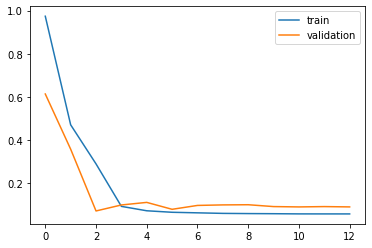


predict: [[29.92759287 24.16289248]]
real:      [[31.2 23.2]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 0.8103 - mean_squared_error: 0.8916 - val_loss: 0.3618 - val_mean_squared_error: 0.1421
Epoch 2/1000
 - 1s - loss: 0.2785 - mean_squared_error: 0.1066 - val_loss: 0.1656 - val_mean_squared_error: 0.0368
Epoch 3/1000
 - 1s - loss: 0.0839 - mean_squared_error: 0.0110 - val_loss: 0.1278 - val_mean_squared_error: 0.0320
Epoch 4/1000
 - 1s - loss: 0.0646 - mean_squared_error: 0.0067 - val_loss: 0.0922 - val_mean_squared_error: 0.0141
Epoch 5/1000
 - 1s - loss: 0.0600 - mean_squared_error: 0.0058 - val_loss: 0.0999 - val_mean_squared_error: 0.0191
Epoch 6/1000
 - 1s - loss: 0.0586 - mean_squared_error: 0.0056 - val_loss: 0.1093 - val_mean_squared_error: 0.0209
Epoch 7/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0055 - val_loss: 0.1202 - val_mean_squared_error: 0.0238
Epoch 8/1000
 - 1s - loss: 0.0567 - mean_squared_error: 0.0054 - val_loss: 0.0955 - va

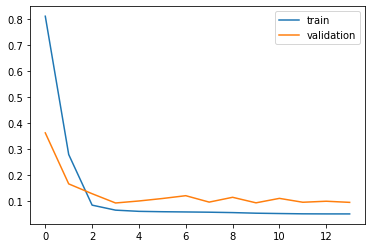


predict: [[31.65784122 23.01860784]]
real:      [[31.  21.1]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 0.8462 - mean_squared_error: 0.7884 - val_loss: 0.2176 - val_mean_squared_error: 0.0605
Epoch 2/1000
 - 1s - loss: 0.1509 - mean_squared_error: 0.0340 - val_loss: 0.0994 - val_mean_squared_error: 0.0141
Epoch 3/1000
 - 1s - loss: 0.0777 - mean_squared_error: 0.0094 - val_loss: 0.1213 - val_mean_squared_error: 0.0222
Epoch 4/1000
 - 1s - loss: 0.0647 - mean_squared_error: 0.0068 - val_loss: 0.0733 - val_mean_squared_error: 0.0097
Epoch 5/1000
 - 1s - loss: 0.0605 - mean_squared_error: 0.0059 - val_loss: 0.0709 - val_mean_squared_error: 0.0087
Epoch 6/1000
 - 1s - loss: 0.0596 - mean_squared_error: 0.0057 - val_loss: 0.0711 - val_mean_squared_error: 0.0087
Epoch 7/1000
 - 1s - loss: 0.0592 - mean_squared_error: 0.0056 - val_loss: 0.0751 - val_mean_squared_error: 0.0098
Epoch 8/1000
 - 1s - loss: 0.0592 - mean_squared_error: 0.0057 - val_loss: 0.0663 - va

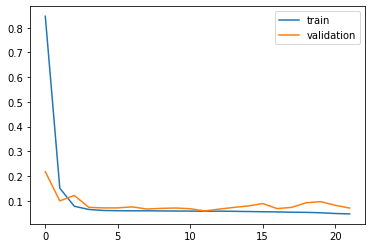


predict: [[31.38100858 22.09762776]]
real:      [[28.7 22.8]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 0.5252 - mean_squared_error: 0.3917 - val_loss: 0.2823 - val_mean_squared_error: 0.1550
Epoch 2/1000
 - 1s - loss: 0.1690 - mean_squared_error: 0.0479 - val_loss: 0.1472 - val_mean_squared_error: 0.0253
Epoch 3/1000
 - 1s - loss: 0.0781 - mean_squared_error: 0.0097 - val_loss: 0.0450 - val_mean_squared_error: 0.0036
Epoch 4/1000
 - 1s - loss: 0.0667 - mean_squared_error: 0.0071 - val_loss: 0.0954 - val_mean_squared_error: 0.0096
Epoch 5/1000
 - 1s - loss: 0.0621 - mean_squared_error: 0.0063 - val_loss: 0.0579 - val_mean_squared_error: 0.0047
Epoch 6/1000
 - 1s - loss: 0.0618 - mean_squared_error: 0.0062 - val_loss: 0.1087 - val_mean_squared_error: 0.0121
Epoch 7/1000
 - 1s - loss: 0.0591 - mean_squared_error: 0.0057 - val_loss: 0.0643 - val_mean_squared_error: 0.0048
Epoch 8/1000
 - 1s - loss: 0.0572 - mean_squared_error: 0.0055 - val_loss: 0.0507 - va

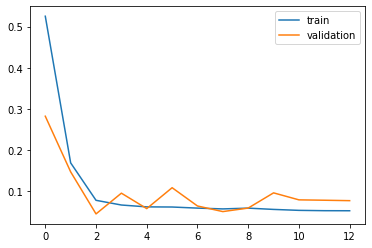


predict: [[31.95010712 20.75364237]]
real:      [[30.1 22.9]]

Train and validation time: 7.505056913693746



In [12]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

mean_scaler = np.mean(values) + 1
dataset_scaled = dataset.div(mean_scaler)

inicio = time.time()
result = NCV(dataset_scaled, days_to_predict, mean_scaler)
fim = time.time()
print('Train and validation time: {}\n'.format((fim - inicio)/60))

In [13]:
y_hats = result[0]
y_tests = result[1]

metrics(y_hats, y_tests)

Maximum metrics
Test RMSE -------------------------- 2.164
Test VARIANCE ---------------------- -1.061
Test MAX-ERROR --------------------- 5.498
Test MEAN-ABSOLUTE-ERROR ----------- 1.629
Test MEDIAN-ABSOLUTE-ERROR --------- 1.17

Errors
30/04/2018 = 2.8194842738870953
29/04/2018 = 3.7326167155811483
28/04/2018 = 0.8923995355815002
27/04/2018 = 0.0023120904618494365
26/04/2018 = 1.2172870264488864
25/04/2018 = 0.9731262602167483
24/04/2018 = 0.3499915354125669
23/04/2018 = 3.0127177581548814
22/04/2018 = 1.6796769929506432
21/04/2018 = 0.26650563682268924
20/04/2018 = 0.5959916259089049
19/04/2018 = 0.081974904506815
18/04/2018 = 0.21108944663570384
17/04/2018 = 4.300136017109246
16/04/2018 = 1.7512775994789962
15/04/2018 = 0.26182255574408586
14/04/2018 = 1.5723407848425985
13/04/2018 = 5.498400439780465
12/04/2018 = 2.1341397367315054
11/04/2018 = 3.3478617976568295
10/04/2018 = 4.159351470994839
9/04/2018 = 1.1223104910472053
8/04/2018 = 0.5931185540328023
7/04/2018 = 0.77100082416